In [1]:
import time
from matplotlib import pyplot as plt
import numpy as np
import mxnet as mx
from mxnet import autograd, gluon
import gluoncv as gcv
from gluoncv.utils import viz
from gluoncv.data import VOCDetection
from gluoncv.data.batchify import Tuple, Stack, Pad
from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
from finetune import VOCLike

Bring the classifier into the workspace

In [5]:
classes = ['brittle_star', 'cnidaria', 'eel', 'misc_fish', 'mollusc',
           'orange_roughy_edge', 'orange_roughy', 'sea_anemone', 'sea_feather',
           'sea_star','sea_urchin']

net = gcv.model_zoo.get_model('ssd_512_mobilenet1.0_custom', classes=classes,
                              pretrained_base=False)

net_wght = '/home/ec2-user/SageMaker/csiro-aos-object-detection/clf-outputs/010221-ssd_512_mobilenet1.0_voc_roughy_OPall_10.params'

# load the weights
net.load_parameters(net_wght)

# put on the GPU [just run on CPU for now - ECO 020721]
# net.collect_params().reset_ctx(contx)

grab a test image and process it

In [18]:
img_ptf = '/home/ec2-user/SageMaker/csiro-aos-object-detection/VOCportALL/OP/JPEGImages/20190713-041806-153.jpg'
x, img = gcv.data.transforms.presets.ssd.load_test(img_ptf, 512)

Run it and explore the outputs

In [19]:
cid, score, bbox = net(x)

In [9]:
print(score.shape)

(1, 100, 1)


In [10]:
print(bbox.shape)

(1, 100, 4)


In [11]:
print(cid.shape)

(1, 100, 1)


In [20]:
print(cid[:, 0:10, :])


[[[6.]
  [6.]
  [6.]
  [6.]
  [6.]
  [6.]
  [6.]
  [6.]
  [6.]
  [6.]]]
<NDArray 1x10x1 @cpu(0)>


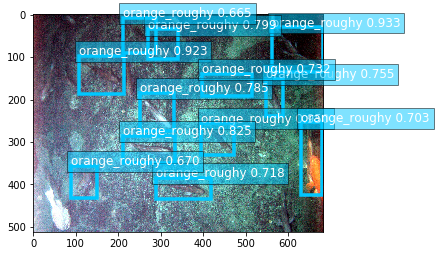

In [21]:
ax = viz.plot_bbox(img, bbox[0], score[0], cid[0], class_names=classes)
plt.show()

In [24]:
print(score[0])


[[ 0.95004386]
 [ 0.9326426 ]
 [ 0.9233766 ]
 [ 0.8245353 ]
 [ 0.79862374]
 [ 0.78543216]
 [ 0.75506353]
 [ 0.7317565 ]
 [ 0.71802723]
 [ 0.7033357 ]
 [ 0.66992545]
 [ 0.66465753]
 [ 0.46878955]
 [ 0.46726862]
 [ 0.45929316]
 [ 0.4430421 ]
 [ 0.43136236]
 [ 0.33352587]
 [ 0.29168296]
 [ 0.28691775]
 [ 0.2840947 ]
 [ 0.24743685]
 [ 0.2294499 ]
 [ 0.22905649]
 [ 0.21586303]
 [ 0.2067384 ]
 [ 0.2032039 ]
 [ 0.19249028]
 [ 0.18432094]
 [ 0.17618929]
 [ 0.16208118]
 [ 0.15974964]
 [ 0.1583059 ]
 [ 0.14772841]
 [ 0.14753595]
 [ 0.14720704]
 [ 0.14104879]
 [ 0.14093962]
 [ 0.13579701]
 [ 0.13330746]
 [ 0.13058273]
 [ 0.12957086]
 [ 0.12852293]
 [ 0.12734623]
 [ 0.1256883 ]
 [ 0.12409426]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.        ]
 [-1.    

In [31]:
from gluoncv.utils.metrics.voc_detection import VOC07MApMetric
from test_trained import get_dataloader

In [33]:
test_set = '/home/ec2-user/SageMaker/csiro-aos-object-detection/VOCportALL/'
test_run = 'OP19/test'
test_dataset = VOCLike(root=test_set, splits=(('OP', f'{test_run}'),))

val_metric = VOC07MApMetric(iou_thresh=0.5, class_names=test_dataset.classes)
print(test_dataset.classes)

# get the test data
test_data = get_dataloader(net, test_dataset, 512, 16, 0, 'ctx')

['brittle_star', 'cnidaria', 'eel', 'misc_fish', 'mollusc', 'orange_roughy_edge', 'orange_roughy', 'sea_anemone', 'sea_feather', 'sea_star', 'sea_urchin']


In [35]:
type(test_data)

mxnet.gluon.data.dataloader.DataLoader

In [42]:
ctx = [mx.cpu(0)]
for batch in test_data:
    data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
    label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)

In [47]:
data[0].shape

(13, 3, 512, 512)

In [49]:
label[0].shape

(13, 29, 6)

In [51]:
det_bboxes = []
det_ids = []
det_scores = []
gt_bboxes = []
gt_ids = []
gt_difficults = []
for x, y in zip(data, label):
    # get prediction results
    ids, scores, bboxes = net(x)
    det_ids.append(ids)
    det_scores.append(scores)
    # clip to image size
    det_bboxes.append(bboxes.clip(0, batch[0].shape[2]))
    # split ground truths
    gt_ids.append(y.slice_axis(axis=-1, begin=4, end=5))
    gt_bboxes.append(y.slice_axis(axis=-1, begin=0, end=4))
    gt_difficults.append(y.slice_axis(axis=-1, begin=5, end=6) if y.shape[-1] > 5 else None)

In [60]:
val_metric.update(det_bboxes, det_ids, det_scores, gt_bboxes, gt_ids, gt_difficults)

In [70]:
val_metric.get()
rr, pp = val_metric._recall_prec()
zz = val_metric._average_precision(rr, pp)

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/gluoncv/utils/metrics/voc_detection.py:292: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if np.sum(rec >= t) == 0:


TypeError: '<=' not supported between instances of 'float' and 'NoneType'

In [117]:
val_metric._n_pos

defaultdict(int,
            {0: 0,
             1: 0,
             2: 0,
             3: 0,
             4: 0,
             5: 0,
             6: 1,
             7: 0,
             8: 0,
             9: 0,
             10: 0})

In [83]:
def get_aps(metric_inst):
    aps = []
    recall, precs = metric_inst._recall_prec()
    for l, rec, prec in zip(range(len(precs)), recall, precs):
        ap = metric_inst._average_precision(rec, prec)
        aps.append(ap)
    return aps

In [119]:
zz = get_aps(val_metric)

In [120]:
zz

[nan, nan, nan, nan, nan, 1.0000000000000002, nan, nan, nan, nan, nan]

In [103]:
zz = det_bboxes[0][1:2,:,:]
zz.shape

(1, 100, 4)

In [118]:
val_metric.reset()
val_metric.update([det_bboxes[0][-1::,:,:]], [det_ids[0][-1::,:,:]], [det_scores[0][-1::,:,:]], 
                  [gt_bboxes[0][-1::,:,:]], [gt_ids[0][-1::,:,:]], [gt_difficults[0][-1::,:,:]])

In [116]:
[det_ids[0][-1::,:,:]]

[
 [[[ 6.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 0.]
   [ 2.]
   [ 5.]
   [ 6.]
   [ 1.]
   [ 4.]
   [ 8.]
   [ 8.]
   [10.]
   [ 3.]
   [ 7.]
   [ 4.]
   [ 9.]
   [ 9.]
   [10.]
   [ 0.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 5.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 6.]
   [ 5.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 6.]
   [ 5.]
   [ 6.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 5.]
   [ 6.]
   [ 5.]
   [ 6.]
   [ 5.]]]
 <NDArray 1x100x1 @cpu(0)>]

In [94]:
ids, scores, bboxes = net(x[5, :, :])

MXNetError: Error in operator ssd2_mobilenet0_conv0_fwd: [14:10:40] src/operator/nn/convolution.cc:152: Check failed: dshp.ndim() == 4U (3 vs. 4) : Input data should be 4D in batch-num_filter-y-x
Stack trace:
  [bt] (0) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x32952b) [0x7fd5b268852b]
  [bt] (1) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(+0xa1e476) [0x7fd5b2d7d476]
  [bt] (2) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x35704fc) [0x7fd5b58cf4fc]
  [bt] (3) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x3573d67) [0x7fd5b58d2d67]
  [bt] (4) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x358d9cf) [0x7fd5b58ec9cf]
  [bt] (5) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(mxnet::CachedOp::SetForwardGraph(mxnet::CachedOp::GraphInfo*, bool, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&)+0x4ac) [0x7fd5b58ef53c]
  [bt] (6) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(mxnet::CachedOp::DynamicForward(mxnet::Context const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, bool)+0x108) [0x7fd5b5900198]
  [bt] (7) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(mxnet::CachedOp::Forward(std::shared_ptr<mxnet::CachedOp> const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&)+0xbaf) [0x7fd5b5902b7f]
  [bt] (8) /home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/libmxnet.so(MXInvokeCachedOp+0x3f0) [0x7fd5b58025d0]

